In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


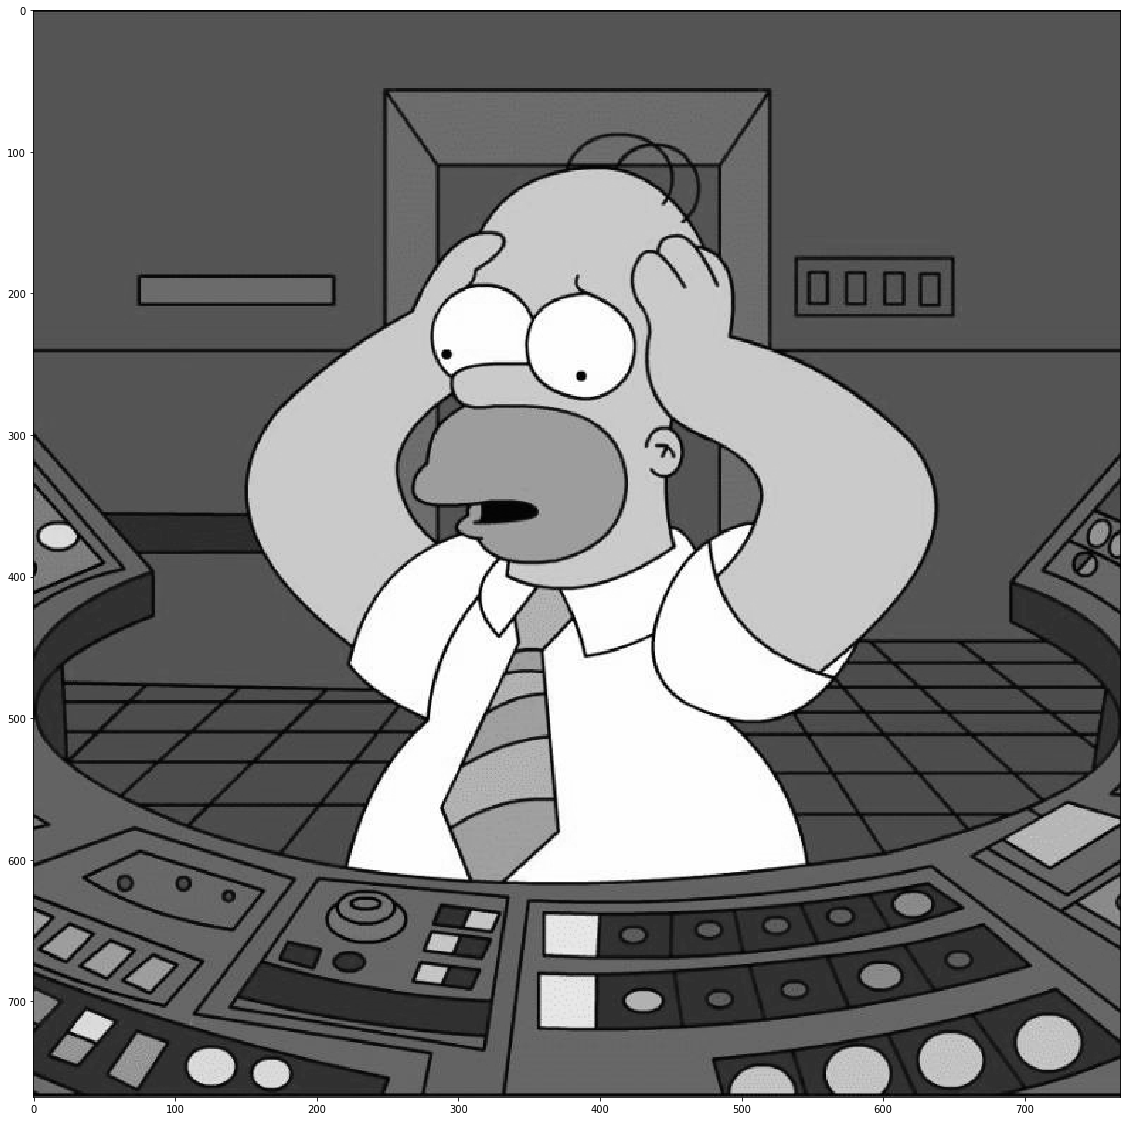

In [2]:
from SLIP import imread
img_orig = imread('../data/homer.jpg')

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_orig, cmap='gray');

# using torch to build up a pyramid

https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate

In [3]:
import torch
img_tens = torch.Tensor(img_orig[None, None, ...])
print('Tensor shape=', img_tens.shape)

Tensor shape= torch.Size([1, 1, 768, 768])


In [4]:
from torch.nn.functional import interpolate
mode='bilinear'
width = 32
base_levels = 1.61803
base_levels = 2

img_down = img_tens
n_levels = 1
while max(img_down.shape) > width :
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
    n_levels += 1
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels)

Tensor shape= torch.Size([1, 1, 384, 384]) , n_levels= 2
Tensor shape= torch.Size([1, 1, 192, 192]) , n_levels= 3
Tensor shape= torch.Size([1, 1, 96, 96]) , n_levels= 4
Tensor shape= torch.Size([1, 1, 48, 48]) , n_levels= 5
Tensor shape= torch.Size([1, 1, 24, 24]) , n_levels= 6


Applying on the central crop of $64\times64$

In [5]:
1024**2 / (40 * 32**2)

25.6

Tensor shape= torch.Size([1, 6, 32, 32])


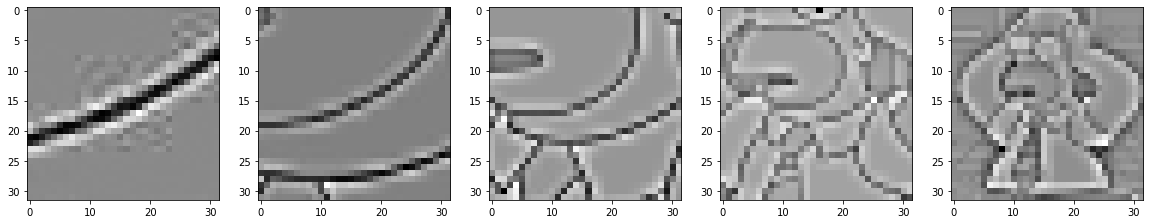

In [6]:
img_tens = torch.Tensor(img_orig[None, None, ...])
img_down = img_tens
img_crop = torch.zeros((1, n_levels, width, width))
fig, axs = plt.subplots(1, n_levels-1, figsize=(20,20))
for i_level, ax in enumerate(axs):
    img_residual = img_down
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
    img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)
    
    h_res, w_res = img_residual.shape[-2:]
    img_crop[0, i_level, :, :] = img_residual[:, :, 
                        (h_res//2-width//2):(h_res//2+width//2), 
                        (w_res//2-width//2):(w_res//2+width//2)]
    
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)

## creating a set of filters

In [7]:
from LogGabor import LogGabor
pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'do_whitening': True,
      'white_name_database': 'kodakdb', 'white_n_learning': 0, 'white_N':
          0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
      'white_steepness': 4.0, 'white_recompute': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.4, 'B_theta': 0.17453277777777776,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}
lg = LogGabor(pe)
print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [8]:
def local_filter(azimuth, theta, phase, sf_0=.3, radius=width/4):

    x, y = lg.pe.N_X//2, lg.pe.N_Y//2 # center
    x += radius * np.cos(azimuth)
    y += radius * np.sin(azimuth)
    
    return lg.normalize(lg.invert(
        lg.loggabor(x, y, sf_0=sf_0, B_sf=lg.pe.B_sf, theta=theta, B_theta=lg.pe.B_theta) * np.exp(-1j * phase)))

K = local_filter(azimuth=0, theta=0, phase=0, radius=width/4)
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

K shape= (32, 32)
K min max= -0.4178787932077425 1.0


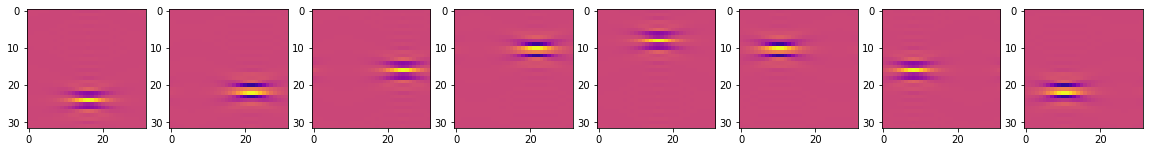

In [9]:
n_test = 8
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=i_azimuth*2*np.pi/n_test, 
                           theta=0, phase=0), vmin=-1, vmax=1, cmap='plasma')


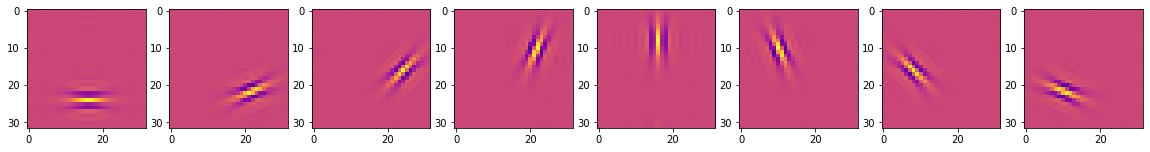

In [10]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=i_azimuth*2*np.pi/n_test, 
                           theta=i_azimuth*np.pi/n_test, phase=0), vmin=-1, vmax=1, cmap='plasma')


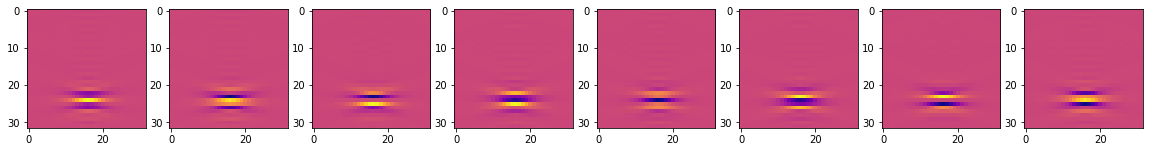

In [11]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_phase, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=0, theta=0, phase=i_phase*2*np.pi/n_test), vmin=-1, vmax=1, cmap='plasma')


In [12]:

n_azimuth = 8 
n_theta = 12
n_phase = 2

#K = np.zeros((width*width, n_azimuth*n_theta*n_phase))
K = np.zeros((width, width, n_azimuth*n_theta*n_phase))
i_ = 0
for i_azimuth in range(n_azimuth):
    for i_theta in range(n_theta):
        for i_phase in range(n_phase):
            #i_ = i_azimuth * n_theta*n_phase + i_theta * n_phase + i_phase
            #print(i_)
            K[..., i_] = local_filter(azimuth=i_azimuth*2*np.pi/n_azimuth, 
                                       theta=i_theta*np.pi/n_theta, 
                                       phase=i_phase*np.pi/n_phase)#.ravel()
            i_ += 1
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

K shape= (32, 32, 192)
K min max= -1.0 1.0


## applying the filter

In [13]:
K_ = torch.Tensor(K)
print('Tensor shape=', K_.shape)

Tensor shape= torch.Size([32, 32, 192])


In [14]:
print('Tensor shape=', img_crop.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


In [15]:
# torch.einsum('i, j, k, l->ij', img_crop, K_)


https://pytorch.org/docs/1.2.0/nn.functional.html#linear

r"""
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`.

Shape:

    - Input: :math:`(N, *, in\_features)` where `*` means any number of
      additional dimensions
    - Weight: :math:`(out\_features, in\_features)`
    - Bias: :math:`(out\_features)`
    - Output: :math:`(N, *, out\_features)`
"""


In [16]:
img_crop_ = img_crop.reshape((1, 6, 1024))
print('Tensor shape=', img_crop_.shape)

Tensor shape= torch.Size([1, 6, 1024])


In [17]:
#from torch.nn.functional import linear
#out = linear(img_crop_[0, :, :], K_, bias=None)

https://pytorch.org/docs/master/torch.html#torch.pinverse

In [18]:
#torch.dot?

In [19]:
#torch.dot(torch.rand(5, 4), torch.rand(5, 4))

In [20]:
torch.tensordot?

Signature: torch.tensordot(a, b, dims=2)
Docstring:
Returns a contraction of a and b over multiple dimensions.

:attr:`tensordot` implements a generalized matrix product.

Args:
  a (Tensor): Left tensor to contract
  b (Tensor): Right tensor to contract
  dims (int or tuple of two lists of integers): number of dimensions to
     contract or explicit lists of dimensions for :attr:`a` and
     :attr:`b` respectively

When called with an integer argument :attr:`dims` = :math:`d`, and the number of
dimensions of :attr:`a` and :attr:`b` is :math:`m` and :math:`n`, respectively,
it computes

.. math::
    r_{i_0,...,i_{m-d}, i_d,...,i_n}
      = \sum_{k_0,...,k_{d-1}} a_{i_0,...,i_{m-d},k_0,...,k_{d-1}} \times b_{k_0,...,k_{d-1}, i_d,...,i_n}.

When called with :attr:`dims` of the list form, the given dimensions will be contracted
in place of the last :math:`d` of :attr:`a` and the first :math:`d` of :math:`b`. The sizes
in these dimensions must match, but :attr:`tensordot` will deal with b

In [21]:
%%timeit
out = torch.tensordot(img_crop, K_,  dims=2)

37.6 µs ± 1.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
out = torch.tensordot(img_crop, K_,  dims=2)
print('Tensor shape=', out.shape)

Tensor shape= torch.Size([1, 6, 192])


## reconstruction of cropped central images

### layer by layer

Tensor shape= torch.Size([1, 6, 32, 32])


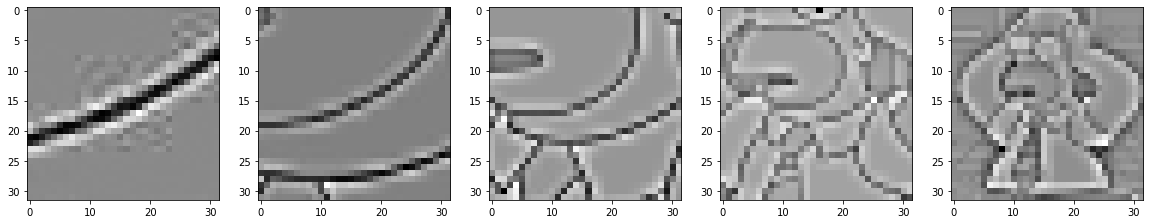

In [23]:
fig, axs = plt.subplots(1, n_levels-1, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)

In [24]:
print('Tensor shape=', K_.shape)
K__ = K_.reshape((1024, n_azimuth*n_theta*n_phase))
print('Tensor shape=', K__.shape)

Tensor shape= torch.Size([32, 32, 192])
Tensor shape= torch.Size([1024, 192])


In [25]:
K_inv = torch.pinverse(K__)
print('Tensor shape=', K_inv.shape)

Tensor shape= torch.Size([192, 1024])


In [26]:
img_rec =  torch.tensordot(out, K_inv,  dims=1).reshape((1, 6, 32, 32))
print('Tensor shape=', img_rec.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


Tensor shape= torch.Size([1, 6, 32, 32])


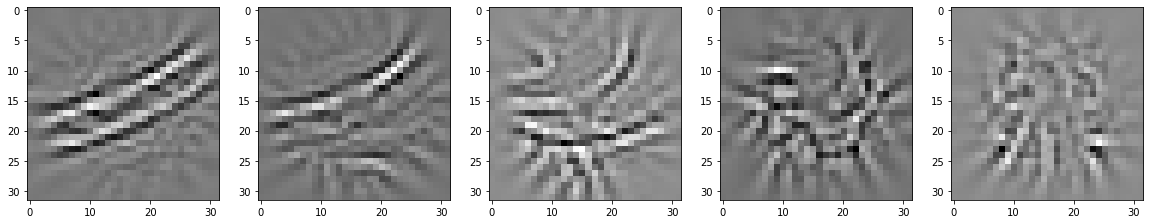

In [27]:
fig, axs = plt.subplots(1, n_levels-1, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_rec.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)

In [28]:
img_rec =  torch.tensordot(out, K__.T,  dims=1).reshape((1, 6, 32, 32))
print('Tensor shape=', img_rec.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


Tensor shape= torch.Size([1, 6, 32, 32])


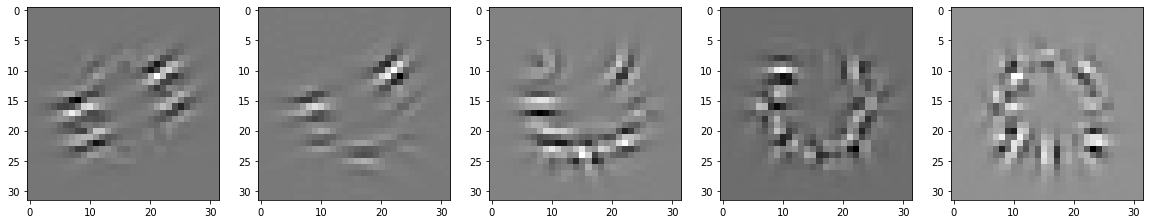

In [29]:
fig, axs = plt.subplots(1, n_levels-1, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_rec.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)


### all layers at once ?

Would require learning ...